In [50]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleModels as nrn
from scipy.ndimage import gaussian_filter1d

In [473]:
def spike_histogram(vs, w=1000, m=10):
    w = int(w)
    m = int(m)
    
    inds = np.arange(w//2, nrn._nitr+1-w//2, m)
    spk_hists = np.zeros(inds.shape)
    # convert to bool index
    bool_spk = vs > 10
    # sum
    for i, ind in enumerate(inds):
        spk_hists[i] = np.sum(bool_spk[i-w//2:i+w//2, :])
    
    t = nrn._times[inds]
    
    return spk_hists, t

In [2]:
params_pn = {'tau':20, 'r':100, 'vth':-40, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':10}
params_pv = {'tau':5, 'r':100, 'vth':-50, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}

In [162]:
label_font_props = {'fontname': 'Helvetica', 'fontsize': 12}
tick_font_props = {'fontname': 'Helvetica', 'fontsize': 8}

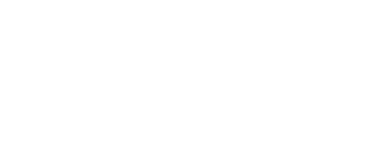

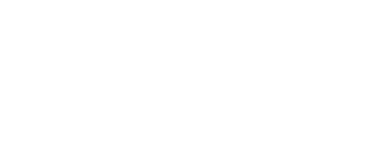

In [534]:
# sample oscillation
t = np.linspace(0, 2/30, 1000)
y1 = np.sin(2*np.pi*30*t)
y2 = np.sin(2*np.pi*60*t)

plt.figure(dpi=150, figsize=(3, 1))
plt.plot(t, y1, 'w', lw=3)
plt.axis('off')
plt.savefig('./figs/sample_30Hz.png')
plt.show()

plt.figure(dpi=150, figsize=(3,1 ))
plt.plot(t, y2, 'w', lw=3)
plt.axis('off')
plt.savefig('./figs/sample_60Hz.png')
plt.show()


# single model

In [3]:
nrn.set_times(tmax=500, dt=0.01)
seed = 102200
nrn.set_seed(seed)

## single cell

In [4]:
Iext = np.zeros(nrn._nitr)
t = nrn._times[1:]
Iext[(t > 100)&(t<400)] = 0.3

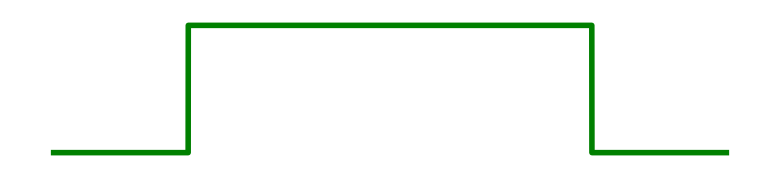

In [150]:
plt.figure(dpi=200, figsize=(4, 1))
plt.plot(nrn._times[1:], Iext,  'g', lw=2)
plt.axis('off')
plt.tight_layout()
plt.savefig('./figs/ext_current.png')
plt.show()

### PN cell

In [6]:
pn = nrn.CellNetwork(**params_pn, Iext=Iext, target_id=[[0]], syn=None, std=0.0)
pn.run()

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 62253.29it/s]


In [7]:
color_pn = np.array([192, 0, 0])/255

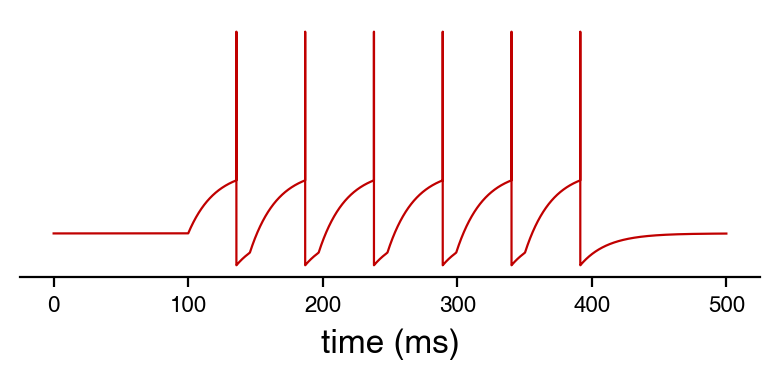

In [163]:
plt.figure(dpi=200, figsize=(4, 2))
plt.plot(nrn._times, pn.vcells[:, 0], c=color_pn, lw=0.8)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yticks([])

plt.xticks(**tick_font_props)
plt.xlabel('time (ms)', **label_font_props)

plt.tight_layout()
plt.savefig('./figs/PN_cell.png')
plt.show()

### PV cell

In [14]:
pv = nrn.CellNetwork(**params_pv, Iext=Iext, target_id=[[0]], syn=None, std=0.0)
pv.run()

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 62498.79it/s]


In [15]:
color_pv = np.array([47, 85, 151])/255

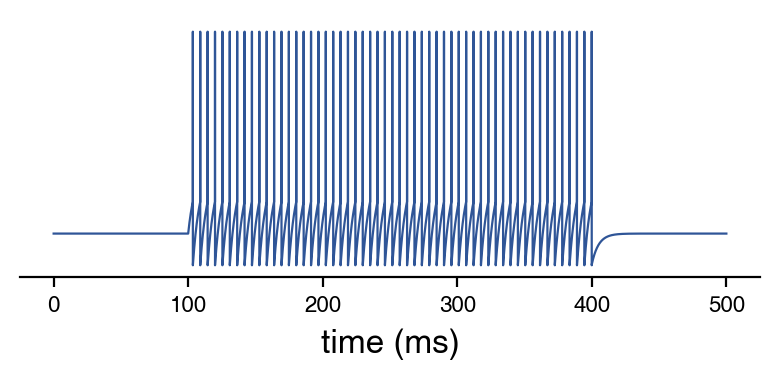

In [164]:
plt.figure(dpi=200, figsize=(4, 2))
plt.plot(nrn._times, pv.vcells[:, 0], c=color_pv, lw=0.8)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yticks([])

plt.xticks(**tick_font_props)
plt.xlabel('time (ms)', **label_font_props)

plt.tight_layout()
plt.savefig('./figs/PV_cell.png')
plt.show()

## firing frequency

In [17]:
nrn.set_times(tmax=300, dt=0.01)

### pn

In [18]:
ii = np.ones(nrn._nitr)
i_amp_pn = np.linspace(0, 1, 50)

# vcells = np.zeros([len(i_amp), nrn._nitr+1])
frs_pn = np.zeros(len(i_amp_pn))

for i, amp in enumerate(i_amp_pn):
    pns = nrn.CellNetwork(**params_pn, Iext=ii*amp, target_id=[[0]], syn=None, std=0.)
    pns.run()
    
    if len(pns.spks[0]) > 2:
        tspks = np.array(pns.spks[0])
        frs_pn[i] = np.average(1e3 / (tspks[1:] - tspks[:-1]))
    elif len(pns.spks[0]) == 2:
        frs_pn[i] = 1e3 / (pns.spks[0][1] - pns.spks[0][0])

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 63287.26it/s]


### pv

In [19]:
ii = np.ones(nrn._nitr)
i_amp_pv = np.linspace(0, 0.5, 50)

# vcells = np.zeros([len(i_amp), nrn._nitr+1])
frs_pv = np.zeros(len(i_amp_pv))

for i, amp in enumerate(i_amp_pv):
    pvs = nrn.CellNetwork(**params_pv, Iext=ii*amp, target_id=[[0]], syn=None, std=0.)
    pvs.run()
    
    if len(pvs.spks[0]) > 2:
        tspks = np.array(pvs.spks[0])
        frs_pv[i] = np.average(1e3 / (tspks[1:] - tspks[:-1]))
    elif len(pns.spks[0]) == 2:
        frs_pv[i] = 1e3 / (pvs.spks[0][1] - pvs.spks[0][0])

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 64930.96it/s]


### figures

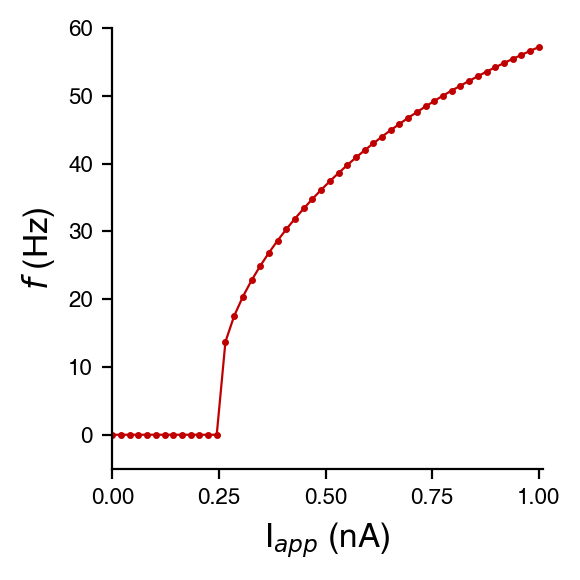

In [166]:
plt.figure(dpi=200, figsize=(3, 3))
plt.plot(i_amp_pn, frs_pn, '.-', c=color_pn, ms=3, lw=0.8)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel(r'I$_{app}$ (nA)', **label_font_props)
plt.ylabel(r'$f$ (Hz)', **label_font_props)
plt.xticks(**tick_font_props)
plt.yticks(**tick_font_props)

plt.xlim([0, i_amp_pn[-1]+0.01])
plt.ylim([-5, 60])


plt.tight_layout()
plt.savefig('./figs/PN_frs.png')

plt.show()

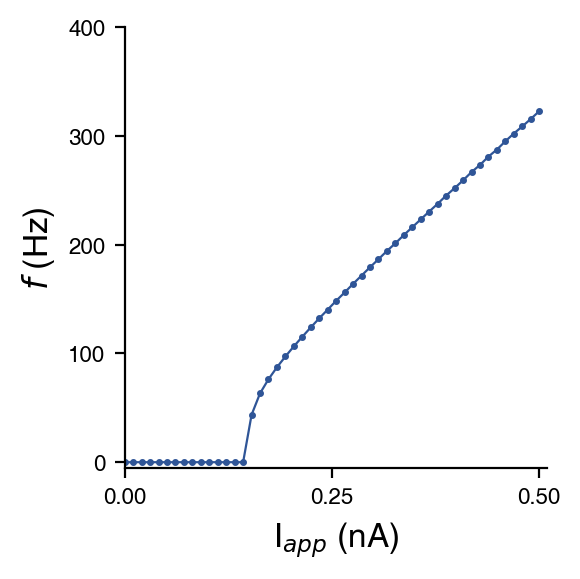

In [167]:
plt.figure(dpi=200, figsize=(3, 3))
plt.plot(i_amp_pv, frs_pv, '.-', c=color_pv, ms=3, lw=0.8)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel(r'I$_{app}$ (nA)', **label_font_props)
plt.ylabel(r'$f$ (Hz)', **label_font_props)
plt.xticks(**tick_font_props)
plt.yticks(**tick_font_props)

plt.xlim([0, i_amp_pv[-1]+0.01])
plt.xticks([0, 0.25, 0.5])
plt.ylim([-5, 400])

plt.tight_layout()
plt.savefig('./figs/PV_frs.png')

plt.show()

## synapse

In [183]:
nrn.set_times(tmax=100, dt=0.01)

In [689]:
syn_pn2pn = {'gbar_syn':0.004, 'tau_r':0.1, 'tau_d':8, 'es':0}
syn_pn2pv = {'gbar_syn':0.002, 'tau_r':0.1, 'tau_d':2, 'es':0}
syn_pv2pn = {'gbar_syn':0.004, 'tau_r':0.1, 'tau_d':4, 'es':-80}
syn_pv2pv = {'gbar_syn':0.001, 'tau_r':0.1, 'tau_d':4, 'es':-80}
# es = [0, 0, -80, -80]
es = [0, -80]

In [700]:
onset = 10
i_alls = np.zeros([nrn._nitr+1, 2])
v_tmp = np.ones([nrn._nitr+1]) * (-65)

for n, syn in enumerate([syn_pn2pv, syn_pv2pn]):#([syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv]):
    B = nrn.get_syn_norm(syn['tau_r'], syn['tau_d'])
    tau1, tau2 = nrn.convert_tau_rdto12(syn['tau_r'], syn['tau_d'])
    gbar = nrn.f_syn(nrn._times, onset, 0, tau1, tau2, B)
    
    i_alls[:, n] = gbar * (v_tmp-es[n])
    

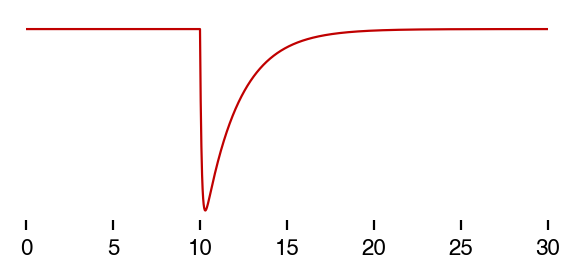

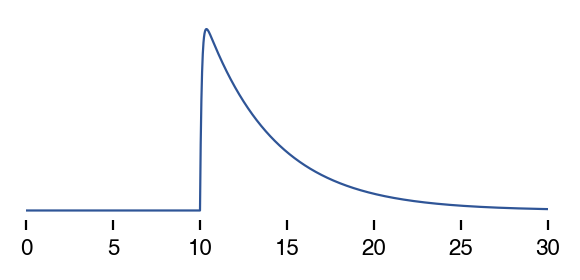

In [722]:
plt.figure(dpi=200, figsize=(3, 1.5))
plt.plot(nrn._times, i_alls[:, 0], lw=0.8, color=color_pn)
# plt.xlabel('time (ms)', **label_font_props)
plt.xlim([0, 30])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.xticks(**tick_font_props)
plt.yticks([])

plt.tight_layout()
plt.savefig('./figs/syn_exc.png')
plt.show()

plt.figure(dpi=200, figsize=(3, 1.5))
plt.plot(nrn._times, i_alls[:, 1], lw=0.8, color=color_pv)
# plt.xlabel('time (ms)', **label_font_props)
plt.xlim([0, 30])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.xticks(**tick_font_props)
plt.yticks([])

plt.tight_layout()
plt.savefig('./figs/syn_inh.png')
plt.show()



# Cell network

In [109]:
# draw connectivity map
from PIL import Image
# load cnt map
cnt_map = np.load('./data/cnt_map.npy')

In [131]:
# set colors
syn_pn2pn = [212, 20, 31]
syn_pn2pv = [231, 190, 60]
syn_pv2pn = [112, 170, 83]
syn_pv2pv = [43, 62, 150]
syn_colors = [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv]

In [139]:
n = cnt_map.shape[0]
m = 20 # expansion params

cnt_color_map = np.ones([n*m, n*m, 3], dtype=np.uint8)*255

for i in range(n):
    for j in range(n):
        tp = cnt_map[i, j]
        if tp != -1:
            for k in range(3):
#                 cnt_color_map[i, j, k] = syn_colors[tp][k]
                cnt_color_map[i*m:(i+1)*m, j*m:(j+1)*m, k] = syn_colors[tp][k]

In [142]:
im = Image.fromarray(cnt_color_map)
# im.show()
im.save('./figs/cnt_map.png')

# one time stimulation

In [65]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

nrn.set_times(tmax=500, dt=0.01)
vs_one = np.load('./data/one_time_stim_v.npy', allow_pickle=True)

In [85]:
vs_one_mean = np.average(vs_one, axis=1)
vs_one_mean = gaussian_filter1d(vs_one_mean, 20)

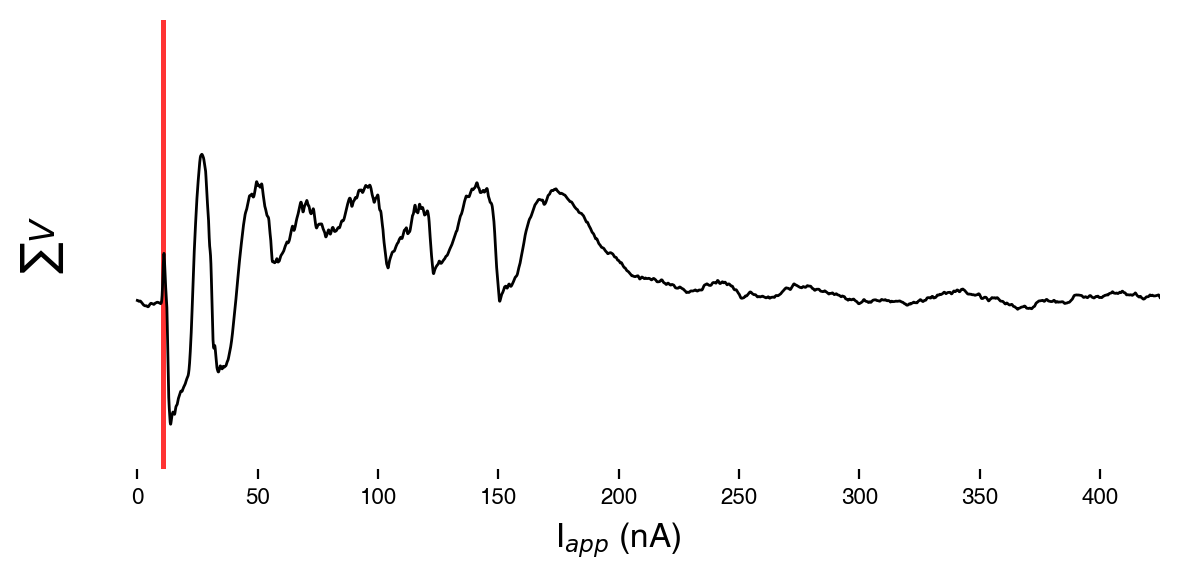

In [178]:
plt.figure(dpi=200, figsize=(6, 3))
plt.plot(nrn._times, vs_one_mean, 'k', lw=1)

rect = Rectangle((10, -100), 2, 100)
pc = PatchCollection([rect], facecolor='r', alpha=0.8, edgecolor=None)
plt.gca().add_collection(pc)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.xlabel(r'I$_{app}$ (nA)', **label_font_props)
plt.ylabel(r'$\sum {V}$', **label_font_props)
plt.xticks(**tick_font_props)
plt.yticks(**tick_font_props)

xl = plt.gca().get_xlim()

plt.xlim([xl[0], 425])
plt.ylim([-80, -40])

plt.yticks([])

plt.tight_layout()
plt.savefig('./figs/one_time_stim.png')

plt.show()

# hetero input

In [536]:
nrn.set_times(tmax=500, dt=0.01)

In [553]:
vs = np.load('./data/heterogen_stim_v.npy', allow_pickle=True)
spks = np.load('./data/heterogen_stim_spk.npy', allow_pickle=True)

n_exc = 80
n_inh = 20

## raster plot

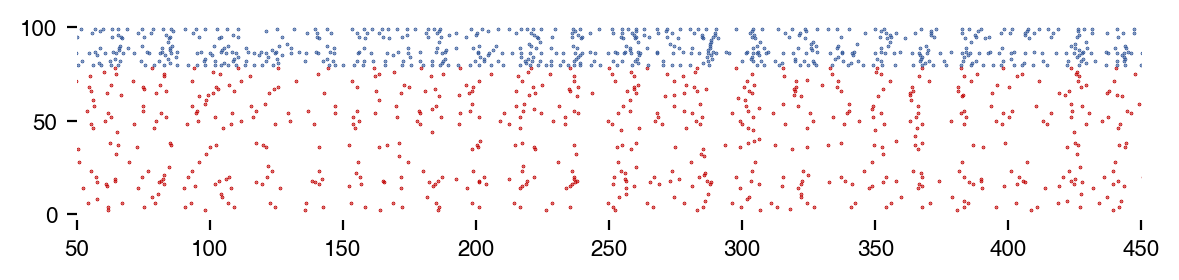

In [480]:
# raster plot
plt.figure(dpi=200, figsize=(6, 1.5))

s = 0.1
alpha = 1

for i, spk in enumerate(spks):
    if len(spk) != 0:
        if i < n_exc:
            plt.scatter(spk, np.ones(len(spk))*i, s=s, color=color_pn, alpha=alpha, edgecolors=None)
        else:
            plt.scatter(spk, np.ones(len(spk))*i, s=s, color=color_pv, alpha=alpha, edgecolors=None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# plt.xlabel(r'time (ms)', **label_font_props)
# plt.ylabel(r'cell number', **label_font_props)
plt.xticks(**tick_font_props)
plt.yticks([0,50,100], **tick_font_props)

plt.xlim([50, 450])

plt.tight_layout()
plt.savefig('./figs/h_raster.png')

plt.show()

## lfp

In [554]:
vsum = np.average(vs, axis=1)
vsum_sm = gaussian_filter1d(vsum, 10)

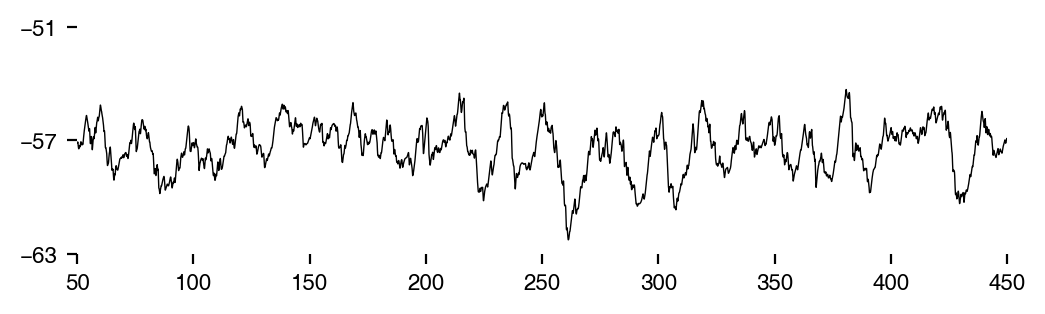

In [481]:
# spike histogram
plt.figure(dpi=200, figsize=(6, 1.5))
plt.plot(nrn._times, vsum_sm, 'k', lw=0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# plt.xlabel('time (ms)', **label_font_props)
# plt.ylabel(r'V$_{m}$ (mV)', **label_font_props)
plt.xticks(**tick_font_props)
plt.yticks([-63, -57, -51], **tick_font_props)

plt.xlim([50, 450])
plt.ylim([-63, -51])

plt.savefig('./figs/h_v.png')

plt.show()

## spike histogram

In [456]:
spk_hists, t = spike_histogram(vs, w=400, m=5)
spk_hists = spk_hists / vs.shape[1] * 100
spk_hists_sm = gaussian_filter1d(spk_hists, 5)

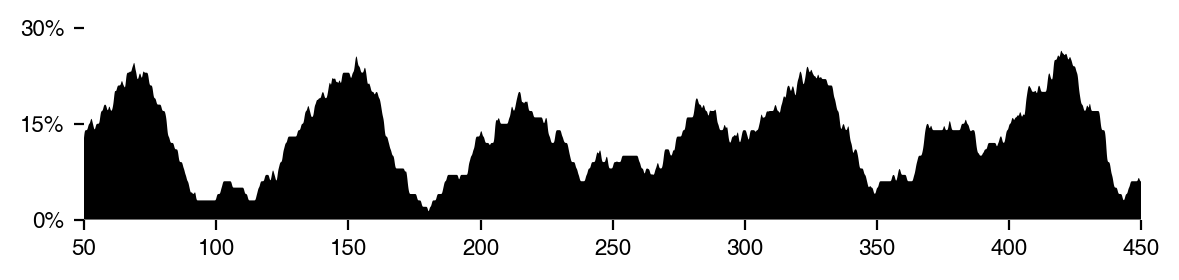

In [482]:
plt.figure(dpi=200, figsize=(6, 1.5))
plt.fill_between(t, spk_hists_sm, facecolor='k', lw=0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

yl = [0, 30]

plt.xlim([50, 450])
plt.ylim(yl)

plt.xticks(**tick_font_props)
plt.yticks([0, yl[1]/2, yl[1]], labels=['%d%%'%(i) for i in [0, yl[1]/2, yl[1]]], **tick_font_props)
# plt.xlabel('time (ms)', **label_font_props)
# plt.ylabel('time (ms)', **label_font_props)

plt.tight_layout()

plt.savefig('./figs/h_hist.png')

plt.show()

## fft result

In [630]:
from scipy.interpolate import interp1d

In [647]:
idt = (nrn._times > 200) & (nrn._times < 250)

f, fx = getFFT(vsum, idt)
idf = f > 10
f = f[idf]
fx = fx[idf]

fx_sm = gaussian_filter1d(fx, 1)

In [664]:
finterp = interp1d(f, fx, 'quadratic')
fnew = np.linspace(30, 100, 1000)

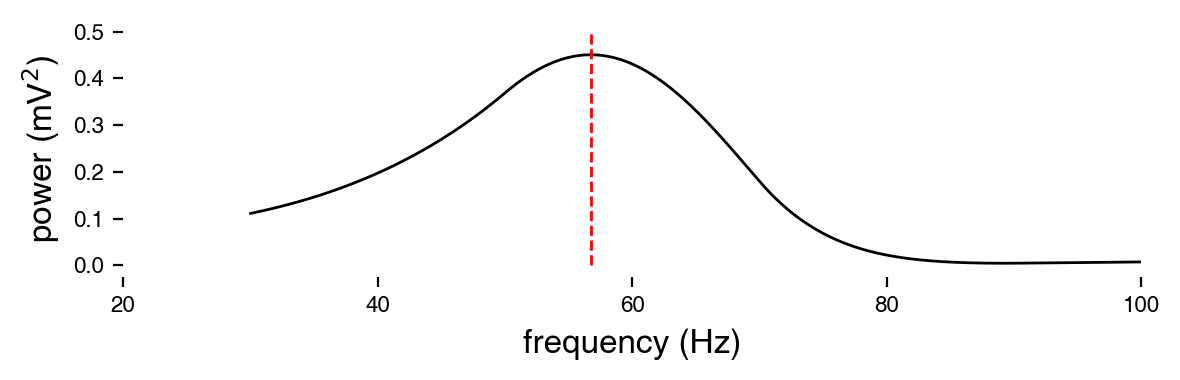

In [683]:
plt.figure(dpi=200, figsize=(6, 2))
y = finterp(fnew)**2

plt.plot(fnew, y, 'k', lw=1)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.xlabel('frequency (Hz)', **label_font_props)
plt.ylabel(r'power (mV$^{2}$)', **label_font_props)

plt.xticks(**tick_font_props)
plt.yticks(**tick_font_props)

plt.xlim([20, 100])
plt.xticks(np.arange(20, 105, 20))
plt.yticks(np.arange(0, 0.51, 0.1))

ind = np.where(y == max(y))[0][0]
# print(ind)
# print(fnew[ind])
plt.plot(np.ones(2) * fnew[ind], [0, 0.5], 'r--', lw=1)

plt.tight_layout()
plt.savefig('./figs/h_fft_result.png')

plt.show()

In [684]:
print(fnew[ind])

56.766766766766764


# w pfc

In [474]:
import os

In [724]:
fdir = './data/w_pfc/'
fnames = os.listdir(fdir)

In [725]:
nrn.set_times(tmax=250, dt=0.01)

In [727]:
fpeaks = np.zeros([10, 10, 10])

idt = (nrn._times>50) & (nrn._times<250)

v_all = []
for i in range(10):
    v_all.append([])
    for j in tqdm(range(10)):
        target_names = [f for f in fnames if 'ntk_calc_vals_%d%d.pickle'%(i, j) in f]
        for k, fname in enumerate(target_names):
            with open(fdir+fname, 'rb') as f:
                v = pickle.load(f)
            v_all[-1].append(v)

            vsum = np.average(v, axis=1)
            
            f, fx = getFFT(vsum, idt)
            idf = f > 1
            f = f[idf]
            fx = fx[idf]
            fpeaks[i, j, k] = find_peak(fx, f)
            

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.79s/it]


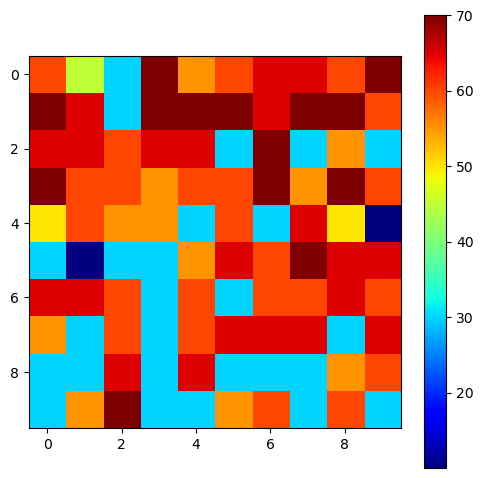

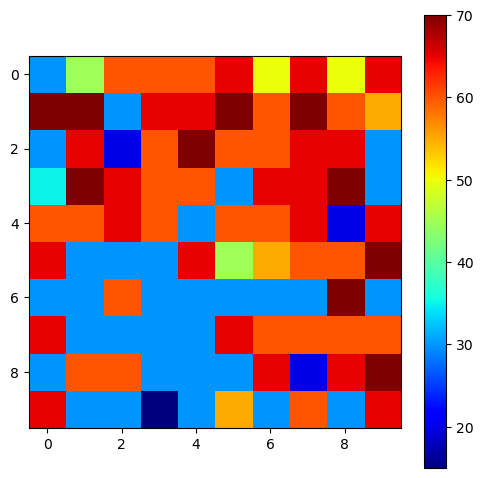

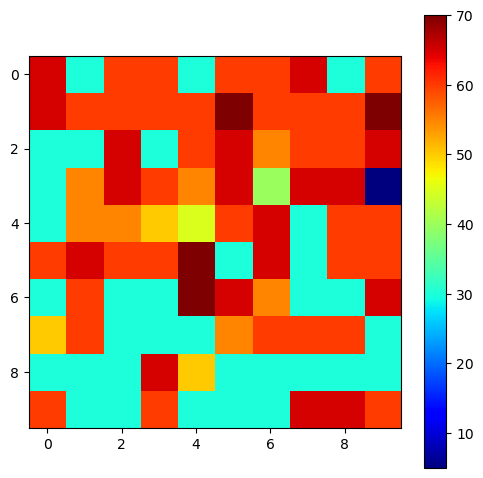

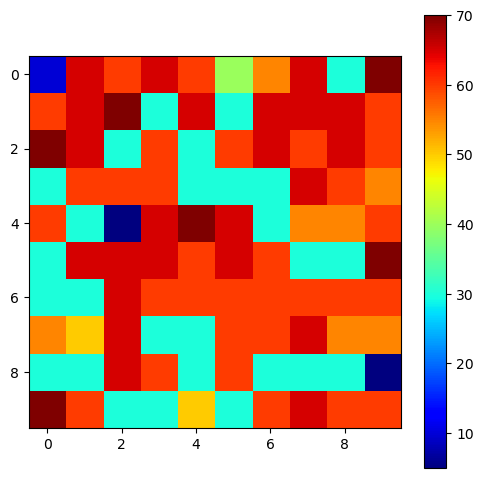

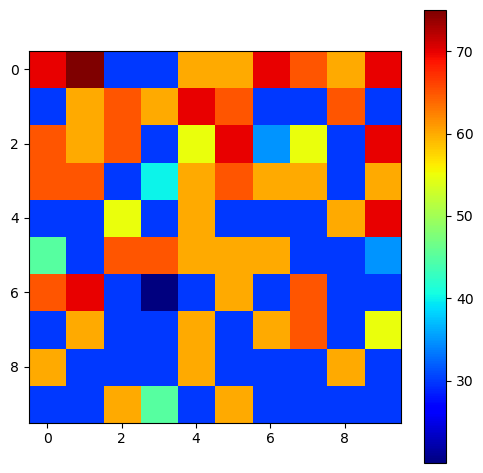

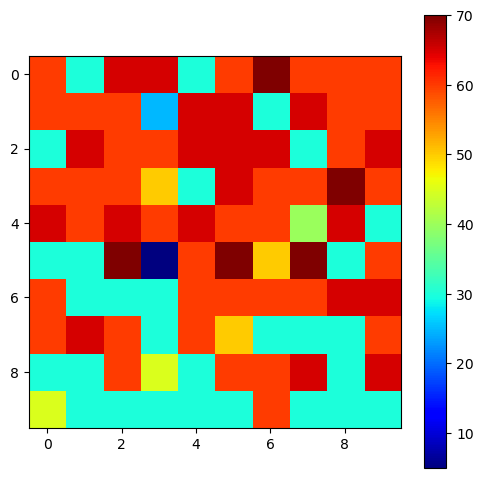

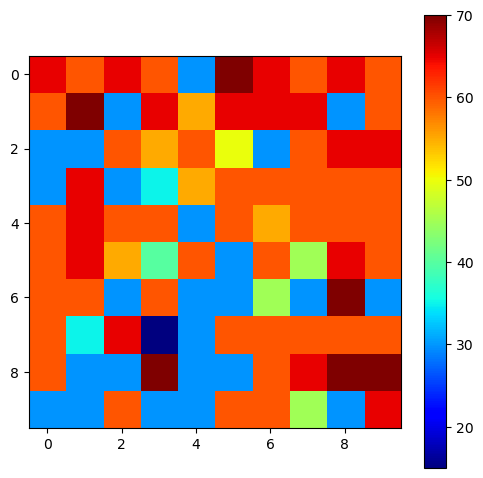

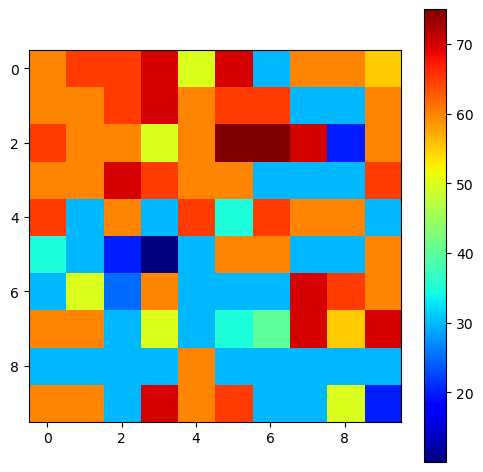

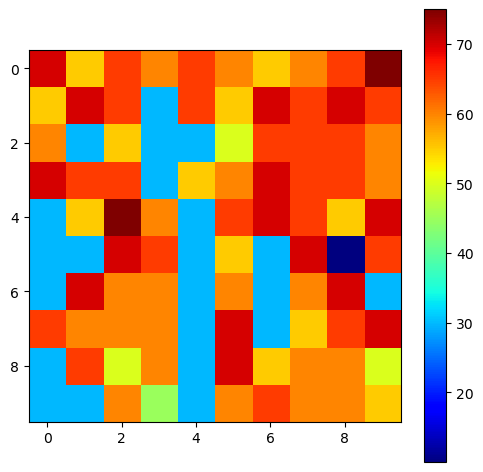

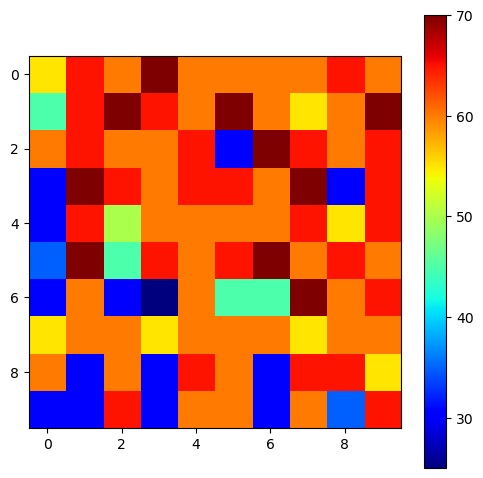

In [510]:
for i in range(10):
    plt.figure(dpi=100, figsize=(6, 6))
    plt.imshow(fpeaks[:, :, i], cmap='jet')
    plt.colorbar()
    plt.show()

In [522]:
gbar_pfc_exc = np.linspace(0, 0.001, 10)
gbar_pfc_inh = np.linspace(0, 0.001, 10)

In [729]:
fx_all = np.load('./fx_all.npy')

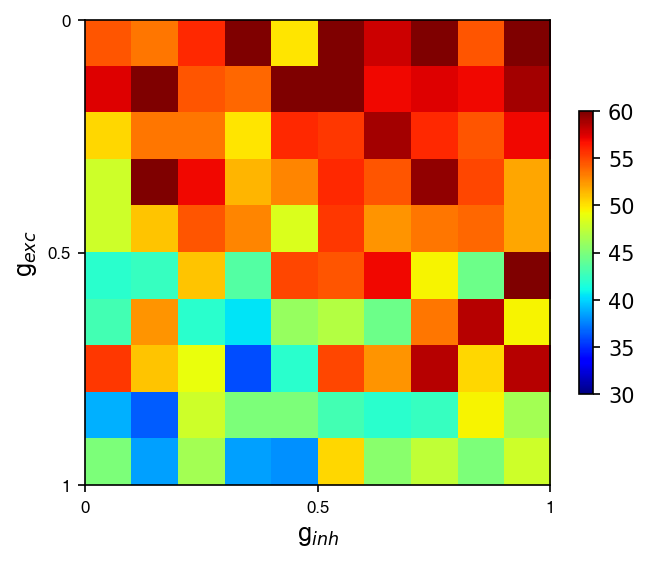

In [739]:
plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(np.average(fpeaks, axis=2), cmap='jet', extent=(gbar_pfc_inh[0], gbar_pfc_inh[-1], gbar_pfc_exc[-1], gbar_pfc_exc[0]),
          vmin=30, vmax=60)
plt.colorbar(shrink=0.5)

plt.xlabel(r'g$_{inh}$', **label_font_props)
plt.ylabel(r'g$_{exc}$', **label_font_props)

plt.xticks([0,0.0005,0.001], labels=[0, 0.5, 1], **tick_font_props)
plt.yticks([0,0.0005,0.001], labels=[0, 0.5, 1], **tick_font_props)

plt.xticks()

plt.show()

In [735]:
fx_all[0][0].shape

(9998,)

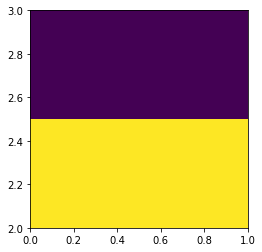

In [521]:
plt.imshow([[0, 0], [1, 1]], extent=(0, 1, 2, 3))

In [496]:
def getFFT(x, idt):
    fx = np.fft.fft(x[idt]) / sum(idt)
    f = np.fft.fftfreq(sum(idt), nrn._dt/(1e3))
    fx = abs(fx[:int(sum(idt)//2)])
    f = f[:int(sum(idt)//2)]
    return f, fx

def find_peak(x, f, idf=None):
    if idf is None:
        idf = np.ones(len(x), dtype=bool)
    ind = np.where(x == max(x[idf]))[0][0]
    return f[ind]

In [489]:
target_names = [f for f in fnames if '%d%d'%(i, j) in f]

In [488]:
i = 1
j = 1


In [490]:
print(target_names)

['7000_ntk_calc_vals_11.pickle', '9000_ntk_calc_vals_11.pickle', '9900_ntk_calc_vals_11.pickle', '4000_ntk_calc_vals_11.pickle', '6000_ntk_calc_vals_11.pickle', '8000_ntk_calc_vals_11.pickle', '3000_ntk_calc_vals_11.pickle', '2000_ntk_calc_vals_11.pickle', '5000_ntk_calc_vals_11.pickle', '1000_ntk_calc_vals_11.pickle']


In [742]:
os.getcwd()

'G:\\내 드라이브\\codes\\network_osc_connectivity\\LIFnetwork'

In [743]:
x = np.load('./data/all_inputs_g.npy')

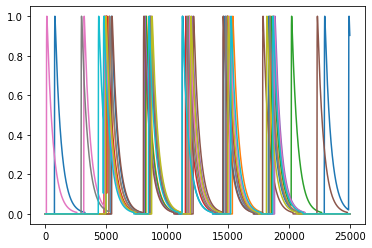

In [746]:
plt.plot(x[:, -10:])

In [ ]:
with open('./data/w_pfc/all_inputs_g.npy', 'rb') as